In [ ]:
#%pip uninstall -y mla_lab
#%pip install -U ../../mla_lab-0.1.9999-py3-none-any.whl

In [49]:
import pandas as pd
from tqdm import tqdm
import os
import swifter
import ast
import re
import numpy as np

tqdm.pandas()

import sklearn.metrics as skm
import matplotlib.pyplot as plt
from socialvec.socialvec import SocialVec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf

## Configs

In [50]:
data_path = "../../Twitter/Data/Volkova/"

data_file = "Volkova_attribues_test_train_split.csv"

train_test_split_by = 'file'

data_file = "volkova_SocialVec_political_augmented_2020.csv"
#data_file = "volkova_SocialVec_political_augmented.csv"

## read and manipulate file

In [51]:
df = pd.read_csv(os.path.join(data_path,data_file),index_col=0)
df.reset_index(inplace=True)
df.shape

(8103, 6)

In [52]:
if data_file == "Volkova_attribues_test_train_split.csv":
    df = df[['user_id','popular_list','political','political_train_test']]
    df.rename(columns={"popular_list":"list"},inplace=True)
    df['source']='volkova'
    requested_source = 'volkova'
else:
    requested_source = 'aug'
    df = df[df['source']=='aug']

In [53]:
df.political.value_counts()

Republican    3470
Democrat      2843
Name: political, dtype: int64

In [54]:
df.list = df.list.swifter.apply(lambda x: list(ast.literal_eval(x.strip())))

Pandas Apply:   0%|          | 0/6313 [00:00<?, ?it/s]

In [56]:
#sv = SocialVec("SocialVec2020_2022.pkl.gz")
sv = SocialVec()
df['socialvec'] = df['list'].progress_apply(lambda x: sv.get_average_embeddings(x)[0])
df['socialvec_len'] = df['list'].progress_apply(lambda x: sv.get_average_embeddings(x)[1])

✅  Initialize Model5h
✅  Load Metadata[?25h


Pandas Apply:   0%|          | 0/6313 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6313 [00:00<?, ?it/s]

## read targets from Volkova for classification

In [57]:
target_name = 'political'
target = target_name + "_enum"

In [58]:
df = df[df[target_name].isin(['Democrat','Republican'])]

In [59]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target_name])

In [60]:
df = df[~df[target_name].isna()]
df.shape

(6313, 9)

In [61]:
#df_test = df[df['source']=='volkova'].copy()#.sample(frac=0.1)

In [62]:
print(df.shape)
sub_df = df[df['source']==requested_source]
sub_df = sub_df[sub_df['socialvec_len']>10]
print(sub_df.shape)

X = sub_df['socialvec']
y = sub_df[target]

(6313, 9)
(6281, 9)


## Check by similarity to BarackObama

In [63]:
if train_test_split_by == 'file':
    df_test = df[df['political_train_test']=='test'].copy()
else:
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                test_size=0.2,
                                                stratify=y,
                                                random_state=7)
    df_test = pd.concat([pd.DataFrame(X_test),
                         pd.DataFrame(y_test)],axis=1)

In [64]:
def paolitical_affiliation(social_vector):
    if sv.get_similarity(social_vector, 'realDonaldTrump') > sv.get_similarity(
            social_vector, 'barackobama'):
        return 1
    else:
        return 0

df_test['pred'] = df_test['socialvec'].progress_apply(political_affiliation)

y_true = list(df_test['political_enum'])
y_score = list(df_test['pred'])

print(f"ROC: {skm.roc_auc_score(y_true, y_score)}")
print(f"f1_score: {skm.f1_score(y_true, y_score)}")
print(f"recall: {skm.recall_score(y_true, y_score)}")
print(f"precision: {skm.precision_score(y_true, y_score)}")


skm.ConfusionMatrixDisplay.from_predictions(y_true, y_score)
plt.show()

NameError: name 'political_affiliation' is not defined

In [ ]:
# Democrat - 0
# Republican - 1

## Train test split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                test_size=0.2,
                                                stratify=y,
                                                random_state=7)

In [66]:
X_train.shape

(5024,)

### Train/Test split as indicated in the file

In [67]:
if train_test_split_by == 'file':
    print('train/test split by file')
    X_train, X_test, y_train, y_test = df[
        df['political_train_test'] == "train"]['socialvec'].values, df[
            df['political_train_test'] == "test"]['socialvec'].values, df[
                df['political_train_test'] ==
                "train"]['political_enum'].values, df[
                    df['political_train_test'] == "test"]['political_enum'].values

train/test split by file


### convert to tensors

In [68]:
X_train_ = []
X_test_ = []

for line in X_train:
    X_train_.append(line.tolist())

for line in X_test:
    X_test_.append(line.tolist())

    X_train_ = tf.stack(X_train_)
X_test_ = tf.stack(X_test_)

# Model Train Test Keras

In [69]:
#tf.keras.backend.clear_session()

# Model train/test Factory


In [ ]:
from hyperopt.pyll.base import scope
from hyperopt import hp

from mlab.utils.modeling.house_model.house_model_config import HouseModelConfig
from mlab.utils.modeling.house_model.mla_neural_net_classifier import MlaNeuralNetClassifier, NeuralNetModelUtils

In [ ]:
# from neuralnet import NeuralNetClassifier
# from model_utilities import ModelUtils
# from hyperopt.pyll.base import scope

In [ ]:
space = {'rate': hp.uniform('rate', 0.01, 0.5),
         'batch_size': scope.int(hp.quniform('batch_size', 25, 200, 25)),
         'epochs' : scope.int(hp.quniform('epochs', 20, 100, 10)),
         'activation': hp.choice('activation', ["relu","sigmoid"]),
         #"activation" : "sigmoid",
         'num_of_hidden_layers': scope.int(hp.quniform('num_of_hidden_layers', 0, 2, 1)),
#          'hidden_layer_dim_0' : scope.int(hp.quniform('hidden_layer_dim_0', 1, 100, 5)),
#          'hidden_layer_dim_1' : scope.int(hp.quniform('hidden_layer_dim_1', 1, 70, 5)),
#          'hidden_layer_dim_2' : scope.int(hp.quniform('hidden_layer_dim_2', 1, 20, 5)), 
         'validation_split':0.2,
         #'num_of_hidden_layers': 0,
         'metrics' : ['accuracy', tf.keras.metrics.AUC()],
         'loss' : 'binary_crossentropy',
         'optimizer' : 'adam',
         "normalize" : False
         }

In [ ]:
tt_model = MlaNeuralNetClassifier(
    HouseModelConfig(hyper_params_dict=space, hyper_opt_iterations=50))

In [ ]:

#pd.DataFrame(X_train,columns=["n"]).explode("n").unstack()

In [ ]:
tt_model.train(pd.DataFrame(pd.DataFrame(X_train)[0].tolist()),y_train)

In [ ]:
tt_model._model.summary()

In [ ]:
tt_model._model.evaluate(pd.DataFrame(pd.DataFrame(X_test)[0].tolist()), y_test)#le.fit_transform(y_test))

In [ ]:
from sklearn import svm

In [ ]:
seed = 8
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)

In [ ]:
clf = svm.SVC(kernel=)
clf.fit(X_train_, y_train)

In [ ]:
clf.predict(X_test_)

# Keras

In [70]:
from keras.layers import Dense, BatchNormalization, Input
from keras.models import Sequential

In [71]:
tf.keras.backend.clear_session()

In [72]:
model = Sequential()
model.add(Dense(100, activation = 'sigmoid'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.AUC()],
              run_eagerly=True)


### model.summary()

In [73]:
loop_range = range(370, len(X_train_), 1000)
#loop_range = range(len(X_train_)-1,len(X_train_))

In [81]:

seed = 8
X_train, X_test, y_train, y_test = train_test_split(X,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=seed)
# Convert to tensors:
X_train_, X_test_ = [], []

for line in X_train:
    X_train_.append(line.tolist())

for line in X_test:
    X_test_.append(line.tolist())

X_train_, X_test_ = tf.stack(X_train_), tf.stack(X_test_)


In [82]:
loop_range

range(370, 6313, 1000)

In [89]:
df_res = pd.DataFrame()

for exp in range(0,6):
    tf.keras.backend.clear_session()
    
    model = Sequential()
    model.add(Dense(100, activation = 'sigmoid'))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',
                  tf.keras.metrics.AUC()],
                  run_eagerly=True)

    for train_subset_size in tqdm(loop_range):
        train_subset_size = min(train_subset_size,5024)

        # Train
        X_subset = tf.slice(X_train_, begin=[0, 0], size=[train_subset_size, 100])
        y_subset = y_train[:train_subset_size]

        model.fit(X_subset,
                  y_subset,
                  epochs=100,
                  batch_size=50,
                  validation_split=0.1,
                  verbose=False)

        preds = model.predict(X_test_).round()

        _, accuracy, auc = model.evaluate(X_test_, y_test, verbose=False)

        df_res = pd.concat([
            df_res,
            pd.DataFrame.from_dict({
                'seed': seed,
                'train_size': train_subset_size,
                'roc_auc' : auc,
                'accuracy' : accuracy,
                'f1_score': [skm.f1_score(preds, y_test)],
                'recall': [skm.recall_score(preds, y_test)],
                'precision': [skm.precision_score(preds, y_test)]
            })
        ])

100%|██████████| 6/6 [05:35<00:00, 55.90s/it]


In [90]:
df_res.columns

Index(['seed', 'train_size', 'roc_auc', 'accuracy', 'f1_score', 'recall',
       'precision'],
      dtype='object')

In [91]:
df_res_mean = df_res.pivot_table(index='train_size',values=['roc_auc', 'accuracy', 'f1_score', 'recall',
       'precision'], aggfunc=['mean'])

In [92]:
df_res_mean.columns = df_res_mean.columns.get_level_values(1)

In [93]:
df_res_mean['type'] = 1

In [94]:
df_res_mean

,accuracy,f1_score,precision,recall,roc_auc,type
train_size,,,,,,
370,0.939936,0.945636,0.953072,0.938321,0.977143,1
1370,0.947892,0.952370,0.950411,0.954348,0.979986,1
2370,0.946036,0.951089,0.956942,0.945349,0.980240,1
3370,0.954256,0.958071,0.953314,0.962911,0.978920,1
4370,0.953328,0.957200,0.952346,0.962192,0.980266,1
5024,0.957836,0.961455,0.959361,0.963583,0.980921,1


In [98]:
df_res_mean_2020 = df_res_mean

In [112]:
def tytest(type_):
    return "SocialVec_2020" if type_ == 1 else "SocialVec_2020_2022"

df_res_mean['type_'] = df_res_mean['type'].apply(tytest)

In [115]:
print(df_res_mean.drop(index=5)[['type_','train_size','accuracy','f1_score','precision','recall','roc_auc']].to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrrrr}
\toprule
{} &                type\_ &  train\_size &  accuracy &  f1\_score &  precision &  recall &  roc\_auc \\
\midrule
0  &       SocialVec\_2020 &         370 &     0.940 &     0.946 &      0.953 &   0.938 &    0.977 \\
1  &       SocialVec\_2020 &        1370 &     0.948 &     0.952 &      0.950 &   0.954 &    0.980 \\
2  &       SocialVec\_2020 &        2370 &     0.946 &     0.951 &      0.957 &   0.945 &    0.980 \\
3  &       SocialVec\_2020 &        3370 &     0.954 &     0.958 &      0.953 &   0.963 &    0.979 \\
4  &       SocialVec\_2020 &        4370 &     0.953 &     0.957 &      0.952 &   0.962 &    0.980 \\
6  &  SocialVec\_2020\_2022 &         370 &     0.954 &     0.957 &      0.939 &   0.976 &    0.982 \\
7  &  SocialVec\_2020\_2022 &        1370 &     0.955 &     0.959 &      0.957 &   0.962 &    0.981 \\
8  &  SocialVec\_2020\_2022 &        2370 &     0.953 &     0.956 &      0.950 &   0.963 &    0.980 \\
9  &  SocialVec\_2020\_2022 &   

In [99]:
df_res_mean = pd.concat([df_res_mean_2020,df_res_mean_2022])

In [102]:
df_res_mean = df_res_mean.reset_index()

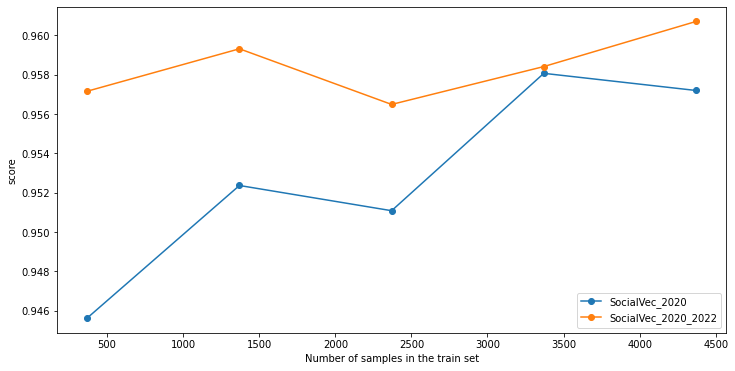

In [111]:
params = ['recall','precision','f1_score']

plt.figure(figsize=(12,6))

for type_ in df_res_mean.type.unique():
    type_text = "SocialVec_2020" if type_ == 1 else "SocialVec_2020_2022"
    plt.plot('train_size', 'f1_score', data=df_res_mean.drop(index=5)[df_res_mean.drop(index=5)['type']==type_], linestyle='-', marker='o', label=type_text)

plt.legend(loc="lower right")
plt.xlabel('Number of samples in the train set')
plt.ylabel('score')

plt.show()

In [33]:
print(df_res_mean.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{lrrrrr}
\toprule
{} &  accuracy &  f1\_score &  precision &  recall &  roc\_auc \\
train\_size &           &           &            &         &          \\
\midrule
370        &     0.954 &     0.957 &      0.939 &   0.976 &    0.982 \\
1370       &     0.955 &     0.959 &      0.957 &   0.962 &    0.981 \\
2370       &     0.953 &     0.956 &      0.950 &   0.963 &    0.980 \\
3370       &     0.955 &     0.958 &      0.952 &   0.965 &    0.981 \\
4370       &     0.957 &     0.961 &      0.957 &   0.965 &    0.980 \\
\bottomrule
\end{tabular}



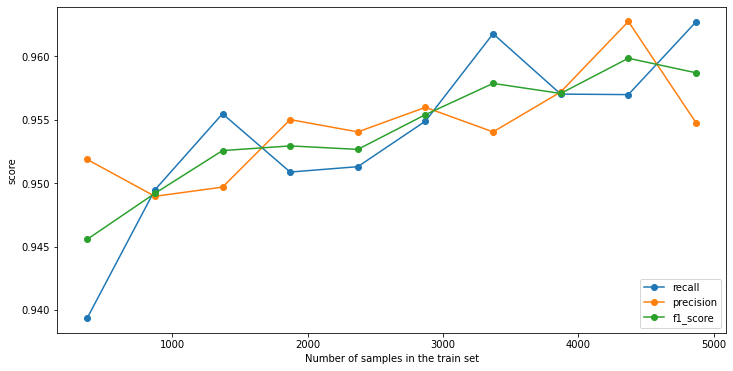

In [49]:
params = ['recall','precision','f1_score']

plt.figure(figsize=(12,6))

for metric in params:
    plt.plot('train_size', metric, data=df_res_mean.reset_index(), linestyle='-', marker='o', label=metric)

plt.legend(loc="lower right")
plt.xlabel('Number of samples in the train set')
plt.ylabel('score')

plt.show()

In [60]:
preds1 = [pred[0] for pred in preds]
compare = pd.DataFrame.from_dict({'preds':preds1,'test':y_test.values})
compare.preds = compare.preds.astype(int)


In [61]:
compare[compare['preds']!=compare['test']].T

,4,9,10,15,19,22,24,27,36,43,...,301,310,311,313,317,318,324,329,331,337
preds,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
test,1,0,0,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,0,1


In [ ]:
model.summary()

In [55]:
from keras.models import save_model

In [59]:
model.save('models/SocialVec_political_2020_2022.h5',save_format='h5')

In [60]:
from keras.models import load_model

reconstructed_model = load_model("models/SocialVec_political_2020_2022.h5")

In [63]:
reconstructed_model.predict(X_test_)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

### save test

In [67]:
test_df_s = pd.DataFrame(X_test)

In [68]:
test_df_s['y'] = y_test

In [70]:
test_df_s.to_csv('test_po.csv')

## confusion Matrix

In [72]:
import sklearn.metrics as skm

In [86]:
y_test = y_test.values
preds = [int(pred[0]) for pred in preds]

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [88]:
preds = [int(pred) for pred in preds]

In [90]:
y_test

array([1, 0, 1, ..., 1, 1, 1])

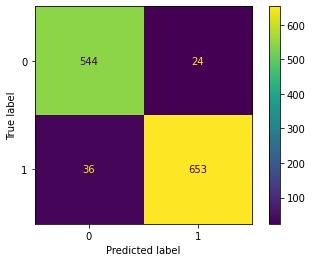

In [97]:
_labels = [0,1]

cm = skm.confusion_matrix(y_test, preds, labels=_labels)

skm.ConfusionMatrixDisplay(
    cm,
    display_labels = _labels).plot()

#plt.show()

In [107]:
test_df_s['p']= model.predict(X_test_)

In [109]:
test_df_s['pred']= test_df_s['p'].round()

In [121]:
test_df_s['confidence'] = abs(test_df_s['p']-0.5)*2

In [123]:
test_df_s['pred']=test_df_s['pred'].astype(int)

In [138]:
p_func = lambda x: 100*x.count()/test_df_s.shape[0]

cmv = test_df_s.pivot_table(index=['y','pred'],values=['confidence'],aggfunc=[p_func,'count','mean','std'])

In [139]:
cmv.columns = cmv.columns.get_level_values(0)

In [140]:
print(cmv.to_latex(float_format="{:0.3f}".format,
                   caption=("Political Classification CM Confidence","This table provides...")))

\begin{table}
\centering
\caption[This table provides...]{Political Classification CM Confidence}
\begin{tabular}{llrrrr}
\toprule
  &   &  <lambda> &  count &  mean &   std \\
y & pred &           &        &       &       \\
\midrule
0 & 0 &    43.278 &    544 & 0.943 & 0.128 \\
  & 1 &     1.909 &     24 & 0.739 & 0.336 \\
1 & 0 &     2.864 &     36 & 0.621 & 0.339 \\
  & 1 &    51.949 &    653 & 0.966 & 0.119 \\
\bottomrule
\end{tabular}
\end{table}



In [143]:
sv.entities.shape

(393516, 4)

In [74]:
df.groupby(by=['political','political_enum']).count()

,,user_id,list,political_train_test,source,socialvec,socialvec_len
political,political_enum,,,,,,
Democrat,0,1363,1363,1363,1363,1363,1363
Republican,1,428,428,428,428,428,428


In [73]:
count_rep = 0
count_dem = 0

for test_location in range(0,sub_df.shape[0]):
    in_test = tf.stack([sub_df.iloc[test_location].socialvec.tolist()])
    single_prediction = int(model.predict(in_test).round()[0][0])
    if sub_df.iloc[test_location].political_enum != single_prediction:
        print(f"twitter_id: {sub_df.iloc[test_location].user_id}, tagged as: {sub_df.iloc[test_location].political_enum} {sub_df.iloc[test_location].political} res: {single_prediction}")
        if single_prediction == 0:
            count_rep = count_rep + 1
        else:
            count_dem = count_dem + 1

twitter_id: 15186859, tagged as: 1 Republican res: 0
twitter_id: 263914867, tagged as: 1 Republican res: 0
twitter_id: 462487376, tagged as: 1 Democrat res: 0
twitter_id: 574250205, tagged as: 0 Republican res: 1
twitter_id: 423941104, tagged as: 1 Democrat res: 0
twitter_id: 454146385, tagged as: 1 Democrat res: 0
twitter_id: 38579155, tagged as: 0 Democrat res: 1
twitter_id: 202798666, tagged as: 1 Democrat res: 0
twitter_id: 337937520, tagged as: 1 Democrat res: 0
twitter_id: 24983393, tagged as: 0 Democrat res: 1
twitter_id: 352486016, tagged as: 0 Democrat res: 1
twitter_id: 536012978, tagged as: 1 Democrat res: 0
twitter_id: 258609027, tagged as: 1 Democrat res: 0
twitter_id: 354125458, tagged as: 1 Republican res: 0
twitter_id: 27992224, tagged as: 1 Republican res: 0
twitter_id: 184547888, tagged as: 1 Democrat res: 0
twitter_id: 427464965, tagged as: 1 Republican res: 0
twitter_id: 359446141, tagged as: 1 Democrat res: 0
twitter_id: 249227650, tagged as: 0 Democrat res: 1
twit

twitter_id: 89033916, tagged as: 1 Democrat res: 0
twitter_id: 349904873, tagged as: 1 Republican res: 0
twitter_id: 328858212, tagged as: 1 Democrat res: 0
twitter_id: 584258797, tagged as: 1 Democrat res: 0
twitter_id: 26589876, tagged as: 0 Democrat res: 1
twitter_id: 257265522, tagged as: 1 Republican res: 0
twitter_id: 104539435, tagged as: 1 Democrat res: 0
twitter_id: 224410857, tagged as: 0 Republican res: 1
twitter_id: 150518148, tagged as: 0 Republican res: 1
twitter_id: 64791948, tagged as: 1 Democrat res: 0
twitter_id: 397717926, tagged as: 1 Democrat res: 0
twitter_id: 401089789, tagged as: 0 Republican res: 1
twitter_id: 238024746, tagged as: 0 Democrat res: 1
twitter_id: 381203261, tagged as: 0 Republican res: 1
twitter_id: 50306226, tagged as: 1 Democrat res: 0
twitter_id: 11146552, tagged as: 0 Democrat res: 1
twitter_id: 110236585, tagged as: 0 Democrat res: 1
twitter_id: 442082078, tagged as: 1 Democrat res: 0
twitter_id: 382359896, tagged as: 1 Democrat res: 0
twitt

twitter_id: 70982412, tagged as: 1 Democrat res: 0
twitter_id: 299441398, tagged as: 1 Democrat res: 0
twitter_id: 177101575, tagged as: 1 Democrat res: 0
twitter_id: 313341167, tagged as: 1 Republican res: 0
twitter_id: 412638454, tagged as: 1 Democrat res: 0
twitter_id: 24537703, tagged as: 1 Democrat res: 0
twitter_id: 387625128, tagged as: 1 Democrat res: 0
twitter_id: 21089214, tagged as: 0 Republican res: 1
twitter_id: 28498427, tagged as: 1 Republican res: 0
twitter_id: 354047009, tagged as: 1 Democrat res: 0
twitter_id: 315296719, tagged as: 1 Democrat res: 0
twitter_id: 82257804, tagged as: 1 Democrat res: 0
twitter_id: 56876875, tagged as: 1 Democrat res: 0
twitter_id: 259541688, tagged as: 1 Republican res: 0
twitter_id: 48157278, tagged as: 1 Democrat res: 0
twitter_id: 22651134, tagged as: 1 Democrat res: 0
twitter_id: 467688815, tagged as: 0 Democrat res: 1
twitter_id: 192385616, tagged as: 1 Democrat res: 0
twitter_id: 77765035, tagged as: 1 Democrat res: 0
twitter_id: 2

In [ ]:
y_test.value_counts()

In [76]:
count_rep

249

In [57]:
df_res_mean.columns = df_res_mean.columns.get_level_values(1)
df_res_mean

,accuracy,f1_score,precision,recall,roc_auc
train_size,,,,,
370,0.784257,0.408834,0.316872,0.579621,0.782305
870,0.796404,0.452260,0.355967,0.620253,0.774228
1370,0.784257,0.431217,0.347737,0.569923,0.765008


ValueError: 'recall' is neither a data key nor a valid format string (unrecognized character 'e')

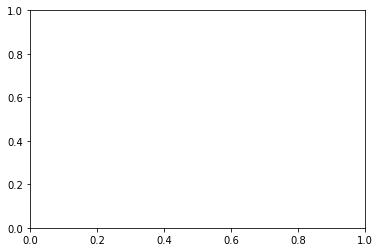

In [27]:
params = ['recall','precision','f1_score']

for metric in params:
    plt.plot('train_size', metric, data=df_res_mean.reset_index(), linestyle='-', marker='o', label=metric)

plt.legend(loc="upper right")
plt.show()

In [ ]:
params = ['roc_auc','accuracy']

for metric in params:
    plt.plot('train_size', metric, data=df_res_mean.reset_index(), linestyle='-', marker='o', label=metric)

plt.legend(loc="upper right")
plt.show()

In [ ]:
df_res #7

In [ ]:
df_res - 42

In [ ]:
model.summary()

In [ ]:
skm.ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.summary()

# sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression

df_res = pd.DataFrame()

for train_subset_size in range(319, len(X_train_), 300):

    X_subset = tf.slice(X_train_, begin=[0,0],size=[train_subset_size,100])
    y_subset = y_train[:train_subset_size]
    
    LR = LogisticRegression(random_state=0,
                            max_iter=200).fit(X_subset,
                                              y_subset)
    preds = np.round(LR.predict(X_test_))
    df_res = pd.concat([df_res,
                        pd.DataFrame.from_dict({'train_size':train_subset_size,
                                                'accuracy': [skm.accuracy_score(preds, y_test)],
                                                'auc': [skm.roc_auc_score(preds, y_test)],
                                                'f1_score': [skm.f1_score(preds, y_test)],
                                                'recall': [skm.recall_score(preds, y_test)],
                                                'precision': [skm.precision_score(preds, y_test)]}
                                              )])
     

In [ ]:
df_res

In [ ]:
skm.roc_auc_score(preds, y_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
params = ['recall','precision','f1_score','auc']

for metric in params:
    plt.plot('train_size', metric, data=df_res, linestyle='-', marker='o', label=metric)

plt.legend(loc="lower right")
plt.show()

## modeling

In [ ]:
model = NeuralNetClassifier()

In [ ]:
X_df = pd.DataFrame()

for line in X:
    X_df = pd.concat([X_df,pd.DataFrame.from_dict(line).T],sort=False)


In [ ]:
model.train_model(X_df,
                  y,
                  hyper_params_dict=space,
                  hyper_opt_iterations=150)

In [ ]:
model.write_model("SocialVec_gender_all.model")

# temp

In [ ]:
params = {}
params['num_of_hidden_layers'] = 3
params['hidden_layer_dim'] = { 0: 50, 1: 30, 2: 20 }

In [ ]:
for layer_num in range(0, params['num_of_hidden_layers']):
    print(params['hidden_layer_dim'][layer_num])